In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import sys
import torch
import numpy as np
from peaknet.utils          import split_dataset
from peaknet.datasets.transform       import center_crop, coord_img_to_crop

timestamp_prev = None
## timestamp_prev = "2022_1026_1049_26"

# Set up parameters for an experiment...
drc_dataset   = 'datasets'
fl_dataset    = 'sfx.0002.npy'
path_dataset  = os.path.join(drc_dataset, fl_dataset)

frac_train    = 0.6
frac_validate = 0.5
dataset_usage = 'train'

base_channels = 8
pos_weight    = 1.0
focal_alpha   = 0.8
focal_gamma   = 2.0

size_batch = 10
lr         = 3*1e-4
seed       = 0

# [[[ DATASET ]]]
# Load raw data...
dataset_list = np.load(path_dataset)
data_train   , data_val_and_test = split_dataset(dataset_list     , frac_train   , seed = seed)
data_validate, data_test         = split_dataset(data_val_and_test, frac_validate, seed = seed)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
%matplotlib inline

In [62]:
timestamp = "2022_1101_1531_08"    # Manual

In [63]:
## timestamp = "2022_1025_1721_42"    # Non manual

In [64]:
from peaknet.methods.unet import UNet
from peaknet.model        import ConfigPeakFinderModel, PeakFinderModel

In [65]:
base_channels = 8
pos_weight    = 1.0
method = UNet( in_channels = 1, out_channels = 1, base_channels = base_channels )
config_peakfinder = ConfigPeakFinderModel( method = method, 
                                           pos_weight = pos_weight, 
                                           focal_alpha = focal_alpha,
                                           focal_gamma = focal_gamma)
model = PeakFinderModel(config_peakfinder)
model.init_params()

In [66]:
model.init_params(from_timestamp = timestamp)   # Run this will load a trained model

In [67]:
# Load model to gpus if available...
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
model  = torch.nn.DataParallel(model.method).to(device)

## Define hooks

In [68]:
# Define hooks...
activation_dict = {}
preactivation_dict = {}
def get_activation(name, tag = ''):
    if tag not in preactivation_dict: preactivation_dict[tag] = {}
    if tag not in activation_dict: activation_dict[tag] = {}
    def hook(model, input, output):
        preactivation_dict[tag][name] = input
        activation_dict[tag][name] = output
    return hook


# Define what layer you want to check...
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.ReLU):
        layer.register_forward_hook(get_activation(name, 'relu'))

    if "final_conv" in name:
        layer.register_forward_hook(get_activation(name, 'final_conv'))

## Visual check

In [69]:
test_img = torch.tensor(data_validate[0][0]).type(dtype=torch.float)[None,].to(device)
test_lbl = torch.tensor(data_validate[0][1]).type(dtype=torch.float)[None,].to(device)

In [70]:
test_img = (test_img - test_img.mean()) / test_img.std()

In [71]:
model.eval()
with torch.no_grad():
    fmap = model.forward(test_img)

In [72]:
fmap.shape

torch.Size([1, 1, 176, 192])

In [73]:
mask_predicted = fmap.sigmoid()

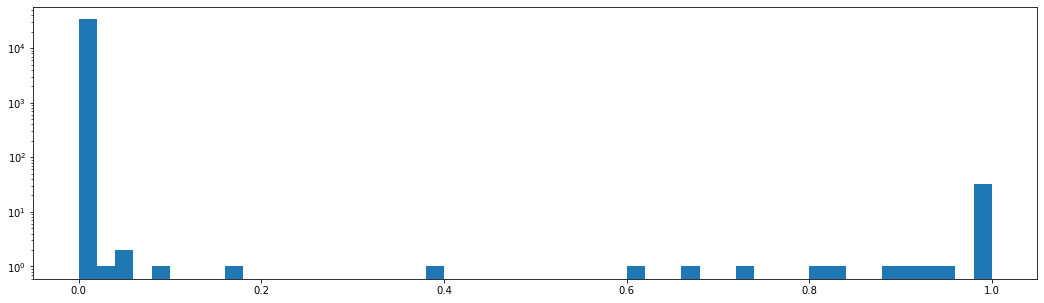

In [74]:
plt.figure(figsize=(18,5))
data = fmap[0, 0].sigmoid().cpu().detach().numpy()
plt.hist(data.reshape(-1), bins = 50);
plt.yscale('log')
# plt.xlim(-2e2,3e2);

### Sigmoid is used to mimic probability

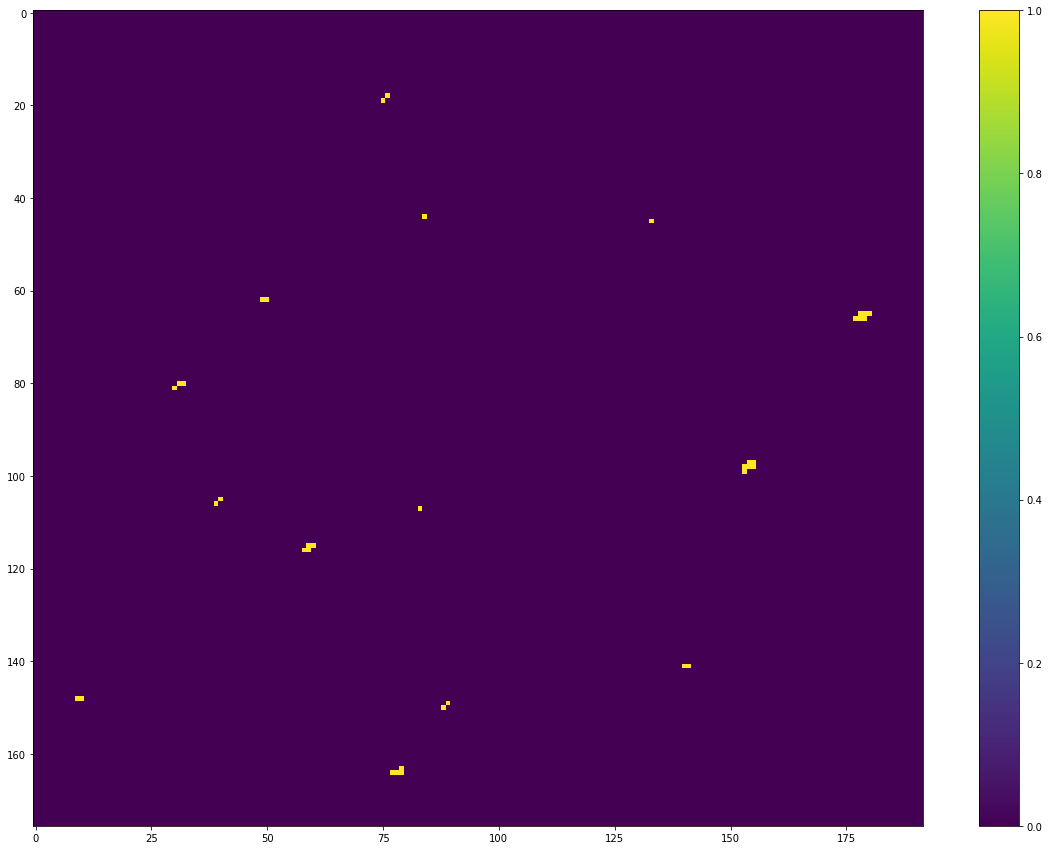

In [75]:
plt.figure(figsize=(20,15))
data = fmap[0, 0].sigmoid().cpu().detach().numpy()
data[data < 0.8] = 0
data[~(data < 0.8)] = 100

plt.imshow(data, vmin = 0, vmax = 1)
plt.colorbar()

In [76]:
test_img.shape

torch.Size([1, 1, 185, 194])

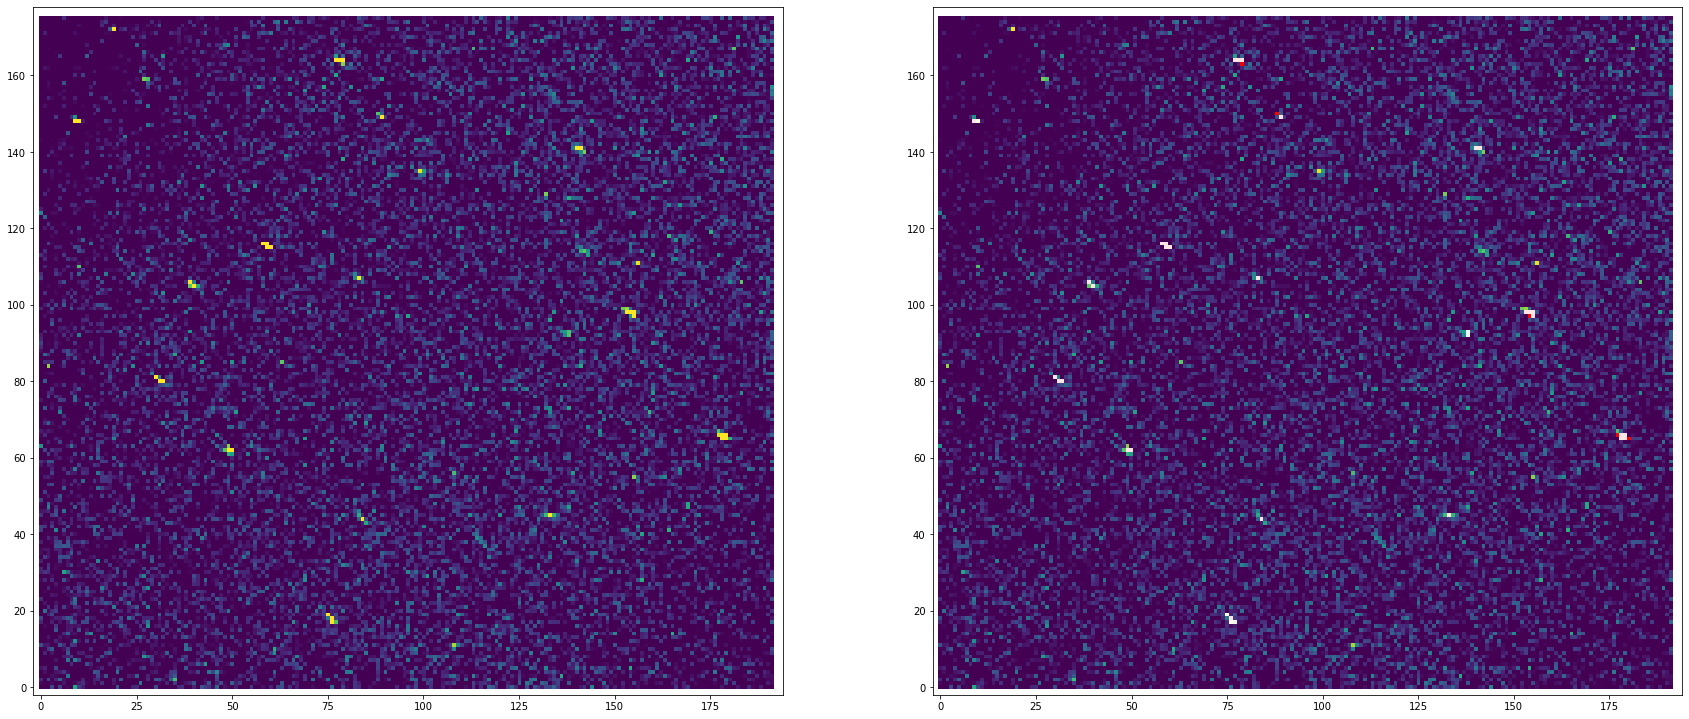

In [77]:
lbl_predicted = fmap.sigmoid()
lbl_predicted[  lbl_predicted < 0.9 ] = 0.0
lbl_predicted[~(lbl_predicted < 0.9)] = 1.0

ncols = 2
nrows = 1
fig   = plt.figure(figsize = (25,18))
gspec = fig.add_gridspec( nrows, ncols,
                          #width_ratios  = [1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/20],
                          #height_ratios = [1/2, 1/2], 
                        )
ax_list = [ fig.add_subplot(gspec[j, i], aspect = 1) for i in range(ncols) for j in range(nrows)]




# Crop the original image...
size_y, size_x = lbl_predicted.shape[-2:]
img_true, offset_tuple = center_crop(test_img, size_y, size_x, return_offset_ok = True)
img_true = img_true.reshape(*img_true.shape[-3:])    # Remove fake batch layer

lbl_true, offset_tuple = center_crop(test_lbl, size_y, size_x, return_offset_ok = True)
lbl_true = lbl_true.reshape(*lbl_true.shape[-3:])    # Remove fake batch layer

img_true       = img_true[0].cpu().detach().numpy()
lbl_true       = lbl_true[0].cpu().detach().numpy()
lbl_predicted  = lbl_predicted[0, 0].cpu().detach().numpy()


vmin = img_true.mean()
vmax = vmin + 6 * img_true.std()
ax_list[0].imshow(img_true, vmin = vmin, vmax = vmax)

im = ax_list[1].imshow(img_true, vmin = vmin, vmax = vmax)
ax_list[1].invert_yaxis()
im = ax_list[1].imshow(lbl_predicted, vmin = 0, vmax = 1, alpha = 1.0)
cmap1 = mcolors.ListedColormap(['none', 'red'])
im.set_cmap(cmap1)

im = ax_list[1].imshow(lbl_true, vmin = 0, vmax = 1, alpha = 0.9)
cmap1 = mcolors.ListedColormap(['none', 'white'])
im.set_cmap(cmap1)

b_offset = 2
y_bmin, x_bmin = 0, 0
y_bmax, x_bmax = size_y, size_x
ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])
ax_list[1].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
ax_list[1].set_ylim([y_bmin - b_offset, y_bmax + b_offset])


fig.subplots_adjust(
    ## top=1-0.049,
    ## bottom=0.049,
    left=0.042,
    right=1-0.042,
    hspace=0.2,
    wspace=0.2
)

## Confusion matrix (validate set)

In [78]:
tp_list = []
fp_list = []
tn_list = []
fn_list = []
for i in range(len(data_validate)):
    test_img = torch.tensor(data_validate[i][0]).type(dtype=torch.float)[None,].to(device)
    test_lbl = torch.tensor(data_validate[i][1]).type(dtype=torch.float)[None,].to(device)
    
    test_img = (test_img - test_img.mean()) / test_img.std()
    
    model.eval()
    with torch.no_grad():
        fmap = model.forward(test_img)
    
    lbl_predicted = fmap.sigmoid()
    lbl_predicted[  lbl_predicted < 0.9 ] = 0.0
    lbl_predicted[~(lbl_predicted < 0.9)] = 1.0
    
    # Crop the original image...
    size_y, size_x = lbl_predicted.shape[-2:]
    img_true, offset_tuple = center_crop(test_img, size_y, size_x, return_offset_ok = True)
    img_true = img_true.reshape(*img_true.shape[-3:])    # Remove fake batch layer

    lbl_true, offset_tuple = center_crop(test_lbl, size_y, size_x, return_offset_ok = True)
    lbl_true = lbl_true.reshape(*lbl_true.shape[-3:])    # Remove fake batch layer

    img_true       = img_true[0].cpu().detach().numpy()
    lbl_true       = lbl_true[0].cpu().detach().numpy()
    lbl_predicted  = lbl_predicted[0, 0].cpu().detach().numpy()
    
    true_np_mask = lbl_predicted == lbl_true
    
    true_peak      = lbl_predicted[true_np_mask]  == 1
    true_non_peak  = lbl_predicted[true_np_mask]  == 0
    false_peak     = lbl_predicted[~true_np_mask] == 1
    false_non_peak = lbl_predicted[~true_np_mask] == 0
    
    tp, fp, tn, fn = true_peak.sum(), false_peak.sum(), true_non_peak.sum(), false_non_peak.sum()
    
    tp_list.append(tp)
    fp_list.append(fp)
    tn_list.append(tn)
    fn_list.append(fn)

tp = np.sum(tp_list)
fp = np.sum(fp_list)    
tn = np.sum(tn_list)    
fn = np.sum(fn_list)    

accuracy    = (tp + tn) / (tp + tn + fp + fn)
precision   = tp / (tp + fp)
recall      = tp / (tp + fn)
specificity = tn / (tn + fp) if tn + fp > 0 else None
f1_inv      = (1 / precision + 1 / recall)
f1          = 2 / f1_inv

In [79]:
print(f"Acc (mean) : {accuracy:.4f}")
print(f"Pre (mean) : {precision:.4f}")
print(f"Rec (mean) : {recall:.4f}")
print(f"F1  (mean) : {f1:.4f}")

Acc (mean) : 0.9997
Pre (mean) : 0.8683
Rec (mean) : 0.6639
F1  (mean) : 0.7525


## Confusion matrix (test set)

In [80]:
tp_list = []
fp_list = []
tn_list = []
fn_list = []
for i in range(len(data_test)):
    test_img = torch.tensor(data_test[i][0]).type(dtype=torch.float)[None,].to(device)
    test_lbl = torch.tensor(data_test[i][1]).type(dtype=torch.float)[None,].to(device)
    
    test_img = (test_img - test_img.mean()) / test_img.std()
    
    model.eval()
    with torch.no_grad():
        fmap = model.forward(test_img)
    
    lbl_predicted = fmap.sigmoid()
    lbl_predicted[  lbl_predicted < 0.9 ] = 0.0
    lbl_predicted[~(lbl_predicted < 0.9)] = 1.0
    
    # Crop the original image...
    size_y, size_x = lbl_predicted.shape[-2:]
    img_true, offset_tuple = center_crop(test_img, size_y, size_x, return_offset_ok = True)
    img_true = img_true.reshape(*img_true.shape[-3:])    # Remove fake batch layer

    lbl_true, offset_tuple = center_crop(test_lbl, size_y, size_x, return_offset_ok = True)
    lbl_true = lbl_true.reshape(*lbl_true.shape[-3:])    # Remove fake batch layer

    img_true       = img_true[0].cpu().detach().numpy()
    lbl_true       = lbl_true[0].cpu().detach().numpy()
    lbl_predicted  = lbl_predicted[0, 0].cpu().detach().numpy()
    
    true_np_mask = lbl_predicted == lbl_true
    
    true_peak      = lbl_predicted[true_np_mask]  == 1
    true_non_peak  = lbl_predicted[true_np_mask]  == 0
    false_peak     = lbl_predicted[~true_np_mask] == 1
    false_non_peak = lbl_predicted[~true_np_mask] == 0
    
    tp, fp, tn, fn = true_peak.sum(), false_peak.sum(), true_non_peak.sum(), false_non_peak.sum()
    
    tp_list.append(tp)
    fp_list.append(fp)
    tn_list.append(tn)
    fn_list.append(fn)

tp = np.nansum(tp_list)
fp = np.nansum(fp_list)    
tn = np.nansum(tn_list)    
fn = np.nansum(fn_list)    

accuracy    = (tp + tn) / (tp + tn + fp + fn)
precision   = tp / (tp + fp)
recall      = tp / (tp + fn)
specificity = tn / (tn + fp) if tn + fp > 0 else None
f1_inv      = (1 / precision + 1 / recall)
f1          = 2 / f1_inv

In [81]:
print(f"Acc (mean) : {accuracy:.4f}")
print(f"Pre (mean) : {precision:.4f}")
print(f"Rec (mean) : {recall:.4f}")
print(f"F1  (mean) : {f1:.4f}")

Acc (mean) : 0.9997
Pre (mean) : 0.8957
Rec (mean) : 0.6575
F1  (mean) : 0.7583
